<h3 style="color: darkblue; font-weight: bold">Introduction</h3>

This notebook attempts to perform **Data Cleaning and Data Preprocessing** and eventually build a **Classification model** to determine whether an email (or email file) is **spam** or **ham** (not spam).

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# for handling and parsing email files
import email
import os
import re
import nltk

from wordcloud import WordCloud
from bs4 import BeautifulSoup
from collections import Counter

# modeling
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.metrics import classification_report, precision_score, recall_score, accuracy_score, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier

<h3 style="color: darkblue; font-weight: bold">Methodology</h3>

There are some steps we will be carrying out for this notebook:

- **Loading and Parsing the files in the dataset using python's `email` module**
- **Getting to know the data/files**
    - This section will contain various sub-sections
    - Example, checking the content of some email files
    - Observing how the emails are structured ([Multipart](https://en.wikipedia.org/wiki/MIME) emails)
    - Calculating the counts of different email structures
- **Data Cleaning**
    - In this section, the raw email files will be converted to plain text
    - Transformations like stripping off the email headers, removing punctuation marks, stemming the words (more on this later) etc... will be performed
- **Preprocessing the Data**
    - In this section a custom transformer will be programmed that will convert the word counts of any email to a vector (`WordCountVectorizer`)
    - The details of this are explained below
- **Classification Models**
    - Lastly, various classification models will be trained on the preprocessed data and their comparisons will be observed

<h3 style="color: darkblue; font-weight: bold">Loading and Parsing the Dataset</h3>

First we load all the email filenames into a python list, and then using the `email` module we parse them.

In [2]:
# load ham and spam files
ham_fnames = [name for name in sorted(os.listdir("/kaggle/input/email-spam-dataset-extended/ham_zipped/main_ham"))]
spam_fnames = [name for name in sorted(os.listdir("/kaggle/input/email-spam-dataset-extended/spam_zipped/main_spam"))]

In [3]:
hl, sl = len(ham_fnames), len(spam_fnames)

print("Number of ham files:", hl)
print("Number of spam files:", sl)
print("Spam to Ham ratio:", sl/hl)
print("Spam percentage: ", (sl / (sl + hl)) * 100, "%")

Number of ham files: 6951
Number of spam files: 2398
Spam to Ham ratio: 0.34498633290174074
Spam percentage:  25.64980211787357 %


We observe that about **25%** files in this dataset are spam files. Below is a helper function to parse email files, based on whether they are **ham** or **spam**.

In [4]:
def parse_email(fname, spam=False):
    directory = "/kaggle/input/email-spam-dataset-extended/spam_zipped/main_spam" if spam else "/kaggle/input/email-spam-dataset-extended/ham_zipped/main_ham"
    with open(os.path.join(directory, fname), "rb") as fp:
        return email.parser.BytesParser().parse(fp)
        
ham_emails = [parse_email(name) for name in ham_fnames]
spam_emails = [parse_email(name, spam=True) for name in spam_fnames]

In [5]:
# total
len(ham_emails + spam_emails)

9349

<h3 style="color: darkblue; font-weight: bold">Getting to know the Data</h3>

Let us explore a test file in `ham_emails` and gain insights about it.

In [6]:
test_email = ham_emails[0]
test_email

We observe that this particular email file is an instance of `email.message.Message`. Now let us know more about its header fields, values and its content.

In [7]:
print("Header fields: ", test_email.keys())
print("Field values: ", test_email.values())
print("Email content: ", test_email.get_payload())

Header fields:  ['Return-Path', 'Delivered-To', 'Received', 'Received', 'Received', 'Received', 'Delivered-To', 'Received', 'Received', 'Received', 'Received', 'Received', 'Received', 'From', 'To', 'Cc', 'Subject', 'In-Reply-To', 'References', 'MIME-Version', 'Content-Type', 'Message-Id', 'X-Loop', 'Sender', 'Errors-To', 'X-Beenthere', 'X-Mailman-Version', 'Precedence', 'List-Help', 'List-Post', 'List-Subscribe', 'List-Id', 'List-Unsubscribe', 'List-Archive', 'Date']
Field values:  ['<exmh-workers-admin@spamassassin.taint.org>', 'yyyy@localhost.netnoteinc.com', 'from localhost (localhost [127.0.0.1])\n\tby phobos.labs.netnoteinc.com (Postfix) with ESMTP id 7106643C34\n\tfor <jm@localhost>; Wed, 21 Aug 2002 08:33:03 -0400 (EDT)', 'from phobos [127.0.0.1]\n\tby localhost with IMAP (fetchmail-5.9.0)\n\tfor jm@localhost (single-drop); Wed, 21 Aug 2002 13:33:03 +0100 (IST)', 'from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by\n    dogma.slashnull.org (8

A very crucial point to note here is that:

**Emails can be multipart**.

Multipart emails allow us to compose an email having various parts or sections. Those parts/sections can contain either plain text or binary data like any image, audio or video.
As seen from [Wikipedia](https://en.wikipedia.org/wiki/MIME):

> Through the use of the multipart type, **MIME** (Multipurpose Internet Mail Extensions) allows mail messages to have parts arranged in a tree structure where the leaf nodes are any non-multipart content type and the non-leaf nodes are any of a variety of multipart types.

Checking the structure of `test_email`...

In [8]:
test_email.get_content_type()

'text/plain'

In [9]:
multi_email = None

for mail in ham_emails:
    if mail.is_multipart():
        multi_email = mail
        break

# Payload will be list of email.message.Message
print(multi_email.get_payload())

# Nested get payload
print(multi_email.get_payload()[0].get_payload())
print(multi_email.items())

[<email.message.Message object at 0x7fb3358cb650>, <email.message.Message object at 0x7fb3358c3110>]
> From:  Valdis.Kletnieks@vt.edu
> Date:  Wed, 21 Aug 2002 02:36:56 -0400
>
> --==_Exmh_778588528P
> Content-Type: text/plain; charset=us-ascii
> 
> On Tue, 20 Aug 2002 22:51:52 EDT, Valdis.Kletnieks@vt.edu said:
> 
> > Ever tried to get MH to *not* have a 'pseq' sequence?  I suspect everybod
> y's
> > looking at a big box that has unseen and pseq in it.  Might want to add
> > 'pseq' to the 'hide by default' list....
> 
> Was it intended that if you added a sequence to the 'never show' list that
> it not take effect till you stopped and restarted exmh?  I added 'pseq',
> then hit 'save' for Preferences - didn't take effect till I restarted.

No it wasn't, and at one point it worked fine.  I'll check and see why it 
stopped working.

Chris
-- 
Chris Garrigues                 http://www.DeepEddy.Com/~cwg/
virCIO                          http://www.virCIO.Com
716 Congress, Suite 200
Austin

We observe that, the `payload` of a multipart email is a list of `email.message.Message` instances (non-leaf nodes) and we need to traverse the tree of a multipart email upto its leaf node to get the actual content, the part contains.

Next, we will count the number of such structures in our entire dataset and see which ones are the most common.

In [10]:
# function to get the structure of email (multipart or single)

def get_structure(email) -> str:
    # can be a non leaf
    payload = email.get_payload()
    if isinstance(payload, list):
        return "multipart({})".format(", ".join(
            get_structure(message)
            for message in payload
        ))
    else:
        return email.get_content_type()

In [11]:
get_structure(test_email)

'text/plain'

In [12]:
get_structure(multi_email)

'multipart(text/plain, application/pgp-signature)'

Using python's `Counter` we will count the number of unique structures, the spam and ham email files have.

In [13]:
# Function to count all the structures
def email_structure_counter(emails):
    structs = Counter()
    for mail in emails:
        mail_struct = get_structure(mail)
        structs[mail_struct] += 1
    return structs

ham_structs = email_structure_counter(ham_emails)
spam_structs = email_structure_counter(spam_emails)

In [14]:
def draw_wordcloud(structs): 
    wordcloud = WordCloud(width=1600, height=800, random_state=3301)
    wordcloud.generate_from_frequencies(frequencies=structs)

    plt.figure( figsize=(20,10), facecolor='k')
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

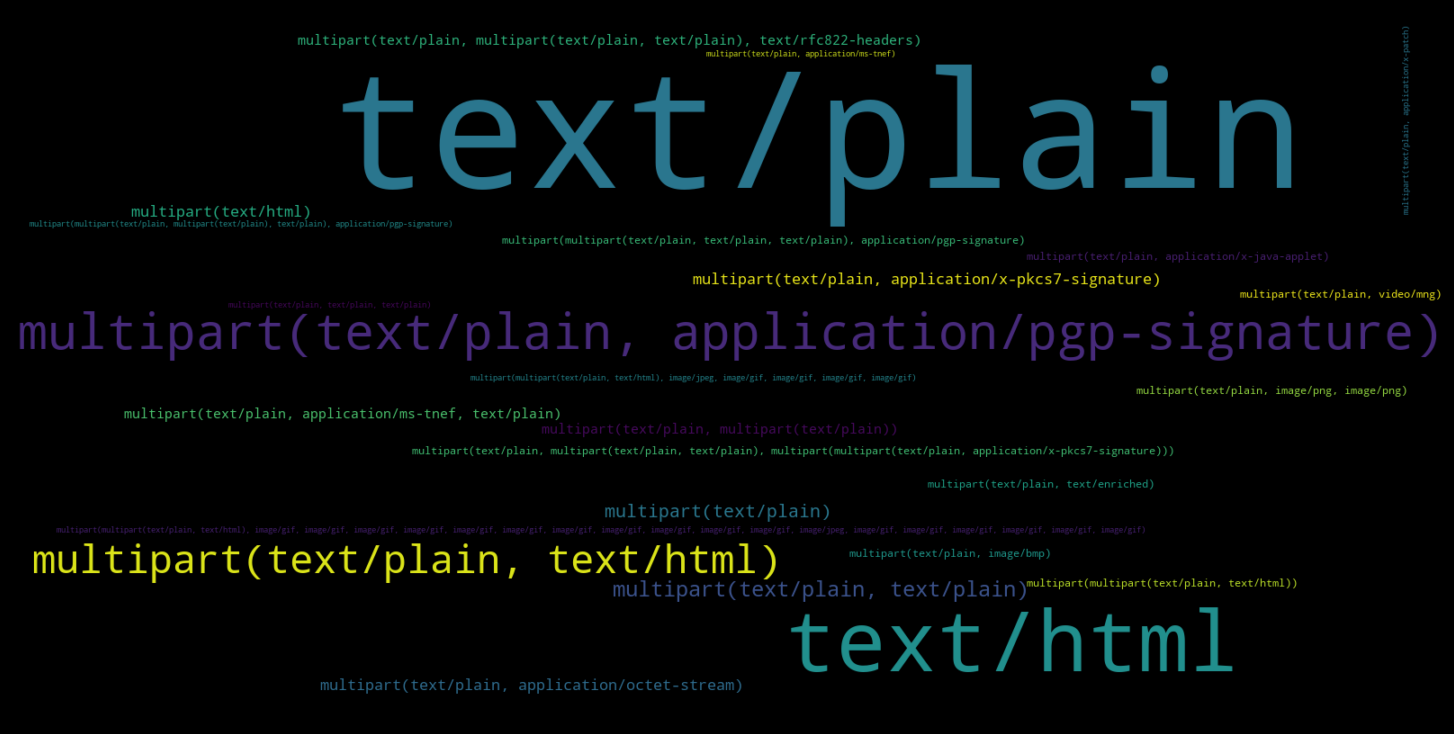

[('text/plain', 6371),
 ('text/html', 240),
 ('multipart(text/plain, application/pgp-signature)', 173),
 ('multipart(text/plain, text/html)', 109),
 ('multipart(text/plain, text/plain)', 9),
 ('multipart(text/plain)', 6),
 ('multipart(text/plain, application/x-pkcs7-signature)', 4),
 ('multipart(text/html)', 4),
 ('multipart(text/plain, application/octet-stream)', 4),
 ('multipart(text/plain, application/ms-tnef, text/plain)', 3),
 ('multipart(text/plain, multipart(text/plain))', 3),
 ('multipart(text/plain, multipart(text/plain, text/plain), text/rfc822-headers)',
  3),
 ('multipart(text/plain, image/bmp)', 2),
 ('multipart(text/plain, text/enriched)', 2),
 ('multipart(multipart(text/plain, text/html))', 2),
 ('multipart(text/plain, image/png, image/png)', 2),
 ('multipart(multipart(text/plain, text/plain, text/plain), application/pgp-signature)',
  2),
 ('multipart(text/plain, video/mng)', 2),
 ('multipart(text/plain, multipart(text/plain, text/plain), multipart(multipart(text/plain,

In [15]:
draw_wordcloud(ham_structs)
ham_structs.most_common()

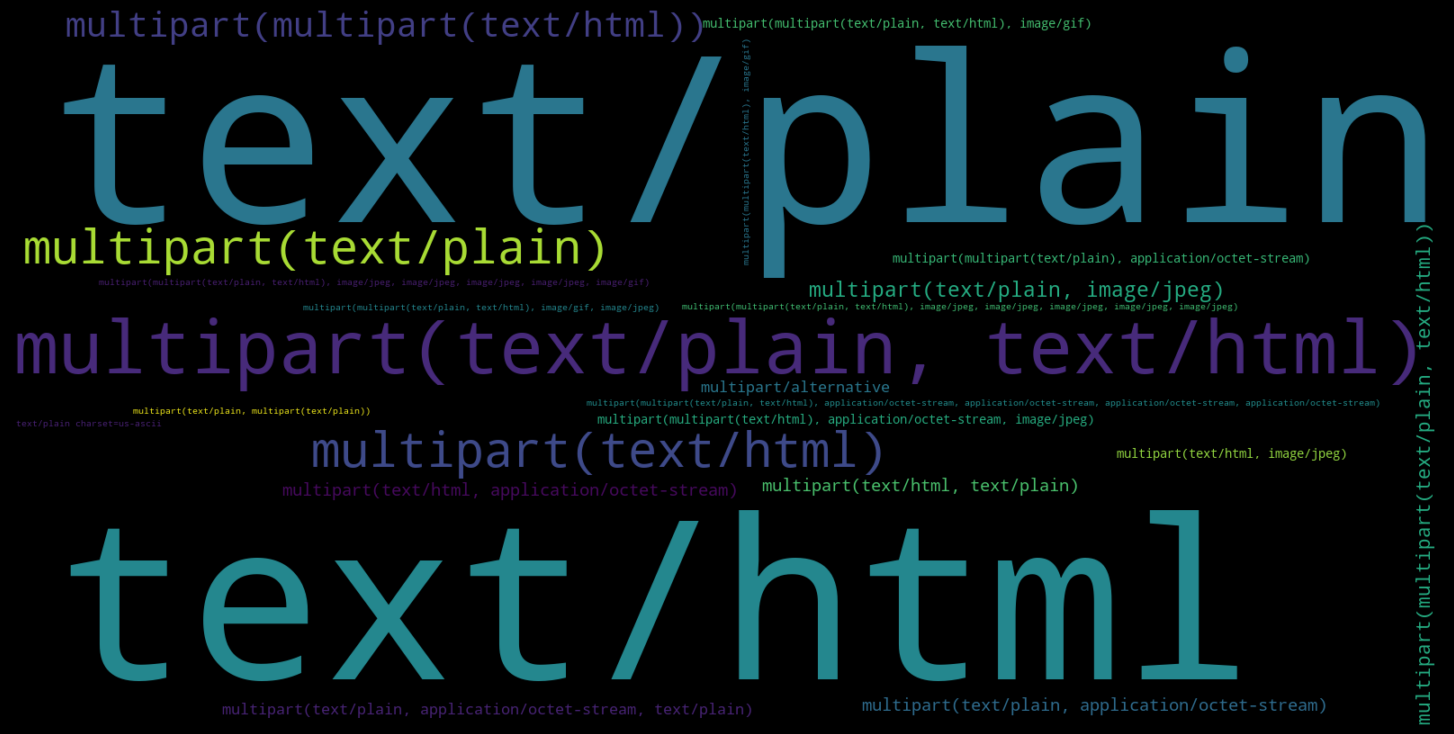

[('text/plain', 1038),
 ('text/html', 953),
 ('multipart(text/plain, text/html)', 204),
 ('multipart(text/html)', 68),
 ('multipart(text/plain)', 63),
 ('multipart(multipart(text/html))', 28),
 ('multipart(text/plain, image/jpeg)', 6),
 ('multipart(multipart(text/plain, text/html))', 5),
 ('multipart(text/plain, application/octet-stream)', 4),
 ('multipart(text/html, text/plain)', 4),
 ('multipart(text/html, application/octet-stream)', 4),
 ('multipart(text/plain, application/octet-stream, text/plain)', 3),
 ('multipart/alternative', 3),
 ('multipart(multipart(text/html), application/octet-stream, image/jpeg)', 2),
 ('multipart(multipart(text/plain, text/html), image/gif)', 2),
 ('multipart(text/html, image/jpeg)', 2),
 ('multipart(multipart(text/plain), application/octet-stream)', 2),
 ('multipart(text/plain, multipart(text/plain))', 1),
 ('multipart(multipart(text/plain, text/html), image/jpeg, image/jpeg, image/jpeg, image/jpeg, image/jpeg)',
  1),
 ('multipart(multipart(text/plain,

In [16]:
draw_wordcloud(spam_structs)
spam_structs.most_common()

Clearly, `text/plain` and `text/html` are the two majority structures in both email types. There are other various types of structures though.

<h3 style="color: darkblue; font-weight: bold">Data Cleaning</h3>

To make a classification model, we need to convert a raw email file into plain text so that we can count the **word frequencies** that can be eventually fed into a Machine Learning model.

But, to convert an email into plain text (which we need eventually for words, in the message content and their counts) we need a **HTML to plain text** converter.
**BeautifulSoup** can do this job for us :D

Example HTML email...

In [17]:
html_email = None

for email in spam_emails:
    if get_structure(email) == 'text/html':
        html_email = email
        break

print(html_email.get_payload())

<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Transitional//EN">
<HTML><HEAD>
<META content=3D"text/html; charset=3Dwindows-1252" http-equiv=3DContent-T=
ype>
<META content=3D"MSHTML 5.00.2314.1000" name=3DGENERATOR></HEAD>
<BODY><!-- Inserted by Calypso -->
<TABLE border=3D0 cellPadding=3D0 cellSpacing=3D2 id=3D_CalyPrintHeader_ r=
ules=3Dnone 
style=3D"COLOR: black; DISPLAY: none" width=3D"100%">
  <TBODY>
  <TR>
    <TD colSpan=3D3>
      <HR color=3Dblack noShade SIZE=3D1>
    </TD></TR></TD></TR>
  <TR>
    <TD colSpan=3D3>
      <HR color=3Dblack noShade SIZE=3D1>
    </TD></TR></TBODY></TABLE><!-- End Calypso --><!-- Inserted by Calypso=
 --><FONT 
color=3D#000000 face=3DVERDANA,ARIAL,HELVETICA size=3D-2><BR></FONT></TD><=
/TR></TABLE><!-- End Calypso --><FONT color=3D#ff0000 
face=3D"Copperplate Gothic Bold" size=3D5 PTSIZE=3D"10">
<CENTER>Save up to 70% on Life Insurance.</CENTER></FONT><FONT color=3D#ff=
0000 
face=3D"Copperplate Gothic Bold" size=3D5 PTSIZE=3D"10">
<CENTER>Why

Next, let us write a helper function for conversion of **HTML** email into **Plain text** email and test it on our example HTML email.

In [18]:
def html_to_text(email) -> str:
    try:
        soup = BeautifulSoup(email.get_payload(), "html.parser")
        plain = soup.text.replace("=\n", "")
        plain = re.sub(r"\s+", " ", plain)
        return plain.strip()
    except:
        return "nothing"

In [19]:
print(html_to_text(html_email))

</TR> Save up to 70% on Life Insurance. Why Spend More Than You Have To? Life Quote Savings Ensuring your family's financial security is very important. Life Quote Savings makes buying life insurance simple and affordable. We Provide FREE Access to The Very Best Companies and The Lowest Rates. Life Quote Savings is FAST, EASY and SAVES you money! Let us help you get started with the best values in the country on new coverage. You can SAVE hundreds or even thousands of dollars by requesting a FREE quote from Lifequote Savings. Our service will take you less than 5 minutes to complete. Shop and compare. SAVE up to 70% on all types of Life insurance! Click Here For Your Free Quote! Protecting your family is the best investment you'll ever make! If you are in receipt of this email in error and/or wish to be removed from our list, PLEASE CLICK HERE AND TYPE REMOVE. If you reside in any state which prohibits e-mail solicitations for insurance, please disregard this email.


This function seems good enough to convert HTML emails to plain text emails.

Now, to convert any email (be it multipart) to plain text, below is a helper function that checks each part/section of an email for text content, captures it and returns.

In [20]:
# General purpose function to convert an email to plain text
def email_to_text(email):
    text_content = ""
    for part in email.walk():
        part_content_type = part.get_content_type()
        if part_content_type not in ['text/plain', 'text/html']:
            continue
        if part_content_type == 'text/plain':
            text_content += part.get_payload()
        else:
            text_content += html_to_text(part)
    return text_content

print("Ham email in plain text:\n", email_to_text(ham_emails[3]))
print("Spam email in plain text:\n", email_to_text(spam_emails[3]))

Ham email in plain text:
 > From:  Valdis.Kletnieks@vt.edu
> Date:  Wed, 21 Aug 2002 02:36:56 -0400
>
> --==_Exmh_778588528P
> Content-Type: text/plain; charset=us-ascii
> 
> On Tue, 20 Aug 2002 22:51:52 EDT, Valdis.Kletnieks@vt.edu said:
> 
> > Ever tried to get MH to *not* have a 'pseq' sequence?  I suspect everybod
> y's
> > looking at a big box that has unseen and pseq in it.  Might want to add
> > 'pseq' to the 'hide by default' list....
> 
> Was it intended that if you added a sequence to the 'never show' list that
> it not take effect till you stopped and restarted exmh?  I added 'pseq',
> then hit 'save' for Preferences - didn't take effect till I restarted.

No it wasn't, and at one point it worked fine.  I'll check and see why it 
stopped working.

Chris
-- 
Chris Garrigues                 http://www.DeepEddy.Com/~cwg/
virCIO                          http://www.virCIO.Com
716 Congress, Suite 200
Austin, TX  78701		+1 512 374 0500

  World War III:  The Wrong-Doers Vs. the Evi

Seems good!

<h3 style="color: darkblue; font-weight: bold">Data Preprocessing</h3>

The ultimate goal of this section is to convert a raw email file into a (sparse) **vector** consisting of the counts of the words in that email message. Since, it would be an overkill to keep track of each and every letter/word in an email, a **vocabulary** of which words to consider the most, must be created.

Before converting an email into a vector of word counts, we need to do some additional preprocessing:

- **Strip off email headers (if any)**
- **Convert the text of an email to lowercase**
- **Remove punctuations from the text of an email**
- **Perform stemming of words**

> Note: Stemming is the process of removing a part of a word, or reducing a word to its stem or root. This might not necessarily mean we’re reducing a word to its dictionary root. 

An example of what stemming is...

In [21]:
text = "Hello, today I am going to London for performing and dancing"
stemmer = nltk.PorterStemmer()

for word in text.split():
    stemmed_word = stemmer.stem(word)
    print(stemmed_word, end=" ")

hello, today i am go to london for perform and danc 

We will split the task of converting an email into a vector of word counts in 2 different transformers:

- **Email to Words Count**: This transformer will transform the email with the 4 above steps first and then it will count the unique words in the email message.
- **Word Count Vectorizer**: This transformer will build a vocabulary from the output of `EmailToWordsCount` and eventually build a sparse Numpy matrix using this vocabulary of words to consider, and their counts.

Lastly, a **pipeline** will be created having these two transformers to effectively transform the raw data to preprocessed data in one go.

**Transformer 1**

In [22]:
class EmailToWordsCount(BaseEstimator, TransformerMixin):
    def __init__(self, strip_headers=True, to_lowercase=True, remove_punc=True, do_stem=True):
        self.strip_headers = strip_headers
        self.to_lowercase = to_lowercase
        self.remove_punc = remove_punc
        self.do_stem = do_stem
        
        # To perform stemming
        self.stemmer = nltk.PorterStemmer()
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_word_counts = []
        for email in X:
            # text of the email
            plain = email_to_text(email)
            if plain is None:
                plain = "nothing"
            
            if self.to_lowercase:
                plain = plain.lower()
            
            if self.remove_punc:
                plain = plain.replace(".", "")
                plain = plain.replace(",", "")
                plain = plain.replace("!", "")
                plain = plain.replace("?", "")
                plain = plain.replace(";", "")
                
            word_counts = Counter(plain.split())
            if self.do_stem:
                # Stem the word, and add their counts
                stemmed_word_counts = Counter()
                for word, count in word_counts.items():
                    root_word = self.stemmer.stem(word)
                    stemmed_word_counts[root_word] += count
                word_counts = stemmed_word_counts
            
            X_word_counts.append(word_counts)
        return np.array(X_word_counts)

Checking if this works as intended...

In [23]:
X_few = spam_emails[1:3]
ewc = EmailToWordsCount()
X_few_counts = ewc.fit_transform(X_few)
print(X_few_counts)

[Counter({'you': 21, 'the': 21, 'and': 14, 'to': 14, 'thi': 12, 'is': 11, 'that': 10, 'of': 10, 'mlm': 8, 'receiv': 7, 'for': 7, 'inform': 6, 'most': 6, 'it': 6, 'be': 6, 'will': 6, 'email': 6, 'in': 5, 'a': 5, 'ha': 5, 'your': 5, 'letter': 4, 'then': 4, 'no': 4, 'peopl': 4, 'work': 4, 'use': 4, 'our': 4, 'list': 4, 'are': 3, 'have': 3, 'about': 3, 'if': 3, "you'v": 3, 'market': 3, 'one': 3, 'their': 3, 'tell': 3, 'there': 3, 'through': 3, 'send': 3, 'i': 3, 'up': 3, 'free': 3, 'or': 3, 'becaus': 2, 'an': 2, 'onlin': 2, 'pleas': 2, 'so': 2, 'been': 2, 'multi-level': 2, 'read': 2, 'ever': 2, 'inbox': 2, 'promis': 2, 'cannot': 2, 'who': 2, 'earn': 2, 'big': 2, 'not': 2, 'someon': 2, "haven't": 2, 'dream': 2, 'with': 2, 'whi': 2, 'sent': 2, 'unsolicit': 2, 'sign': 2, 'system': 2, 'which': 2, 'agre': 2, 'also': 2, 'such': 2, 'greet': 1, 'express': 1, 'interest': 1, 'busi': 1, 'opportun': 1, 'erron': 1, 'accept': 1, 'my': 1, 'sincer': 1, 'apolog': 1, 'one-tim': 1, 'mail': 1, 'remov': 1, 'ne

Seems good enough! Let us move forward.

**Transformer 2**

In [24]:
class WordCountVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, vocabulary_size=1000):
        self.vocabulary_size = vocabulary_size
    # train on list of word counts and build vocabulary
    def fit(self, X, y=None):
        total_word_counts = Counter()
        for word_count in X:
            for word, count in word_count.items():
                total_word_counts[word] += count
                
        # Build a vocabulary out of total most common
        self.most_common = total_word_counts.most_common()[:self.vocabulary_size]
        self.vocabulary_ = {word: i for i, (word, count) in enumerate(self.most_common)}
    
        return self
    # Create the vector out of vocabulary
    def transform(self, X, y=None):
        X_new = np.zeros([X.shape[0], self.vocabulary_size + 1], dtype=int)
        
        # The vectors will contain additional column for counts of words
        # not captured in vocabulary
        for row, word_counts in enumerate(X):
            for word, count in word_counts.items():
                col = self.vocabulary_.get(word, self.vocabulary_size)
                X_new[row, col] += count
                
        return X_new

Checking if this works as intended...

In [25]:
vectorizer = WordCountVectorizer(vocabulary_size=10)
X_few_vector = vectorizer.fit_transform(X_few_counts)

print("Vector of word counts:\n", X_few_vector)
print("Vocabulary generated:\n", vectorizer.vocabulary_)

Vector of word counts:
 [[ 21  21  14  14  12  11  10  10   5   7 368]
 [  7   5   6   5   2   3   3   0   4   2 135]]
Vocabulary generated:
 {'you': 0, 'the': 1, 'to': 2, 'and': 3, 'thi': 4, 'is': 5, 'of': 6, 'that': 7, 'in': 8, 'for': 9}


**NOTE**:

The last column of our vector is the count of remaining words which are not captured by the generated vocabulary.

### Full Pipeline for Data Preprocessing

Using `scikit-learn`'s API let us create a pipeline consisting of these transformers for preprocessing the data in one go.

In [26]:
email_to_cvector = Pipeline([
    ("emailToWords", EmailToWordsCount()), 
    ("wordCountVectorizer", WordCountVectorizer())
])

### Preparing train and test sets

Let us split the entire dataset into Training set and Testing set, for the classification Machine Learning models to train and test on. **80%** data will be used for training while the rest **20%** will be used for testing.

In [27]:
X = np.array(ham_emails + spam_emails)
y = np.array([0] * len(ham_emails) + [1] * len(spam_emails))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=3301)

print("Training set size: ", X_train.shape, y_train.shape)
print("Testing set size: ", X_test.shape, y_test.shape)

Training set size:  (7479,) (7479,)
Testing set size:  (1870,) (1870,)


In [29]:
# prepare the training and testing set 
X_train_prepared = email_to_cvector.fit_transform(X_train)
X_train_prepared

array([[  7,   6,   0, ...,   0,   0,  57],
       [  9,   7,   0, ...,   0,   0,  42],
       [  1,   5,   4, ...,   0,   0,  60],
       ...,
       [ 14,   9,   0, ...,   0,   0, 134],
       [ 33,  20,   0, ...,   1,   0, 125],
       [  0,   3,   0, ...,   0,   0,  17]])

In [30]:
X_test_prepared = email_to_cvector.transform(X_test)
X_test_prepared

array([[  2,   0,   0, ...,   0,   0,  37],
       [ 23,  21,   0, ...,   0,   0, 168],
       [  2,   3,   0, ...,   0,   0,  19],
       ...,
       [ 16,   7,   0, ...,   0,   0,  63],
       [ 31,  41,  33, ...,   0,   0, 164],
       [  0,   4,   0, ...,   0,   0,  22]])

<h3 style="color: darkblue; font-weight: bold">Classification Models</h3>

In this section we will train various classification models on the Training set and compare their results on the Test set.

Here, I have written a custom helper function to compare a list of Classifiers using their **Classification Report** and **Confusion Matrix**.

In [31]:
def comp_esti(esti, Xtr=X_train_prepared, Xte=X_test_prepared, ytr=y_train, yte=y_test):
    esti.fit(Xtr, ytr)
    esti_test_preds = esti.predict(Xte)
    
    print(f"{esti} Accuracy score: ", accuracy_score(yte, esti_test_preds))
    print(f"\n{esti} Classification report:\n", classification_report(yte, esti_test_preds, digits=6))
    
    # confusion matrix
    cf_mat = confusion_matrix(yte, esti_test_preds)
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(data=cf_mat, annot=True, ax=ax)
    plt.show()

Next, we provide a list of classifiers as a parameter to this function...

RandomForestClassifier(random_state=3301) Accuracy score:  0.9855614973262032

RandomForestClassifier(random_state=3301) Classification report:
               precision    recall  f1-score   support

           0   0.986399  0.994228  0.990298      1386
           1   0.983087  0.960744  0.971787       484

    accuracy                       0.985561      1870
   macro avg   0.984743  0.977486  0.981043      1870
weighted avg   0.985542  0.985561  0.985507      1870



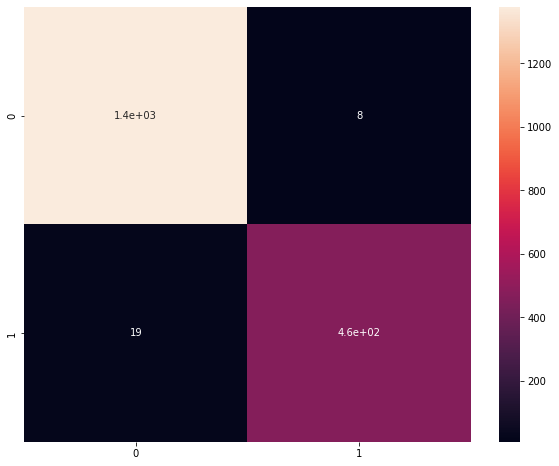

AdaBoostClassifier(random_state=3301) Accuracy score:  0.9668449197860962

AdaBoostClassifier(random_state=3301) Classification report:
               precision    recall  f1-score   support

           0   0.979710  0.975469  0.977585      1386
           1   0.930612  0.942149  0.936345       484

    accuracy                       0.966845      1870
   macro avg   0.955161  0.958809  0.956965      1870
weighted avg   0.967002  0.966845  0.966911      1870



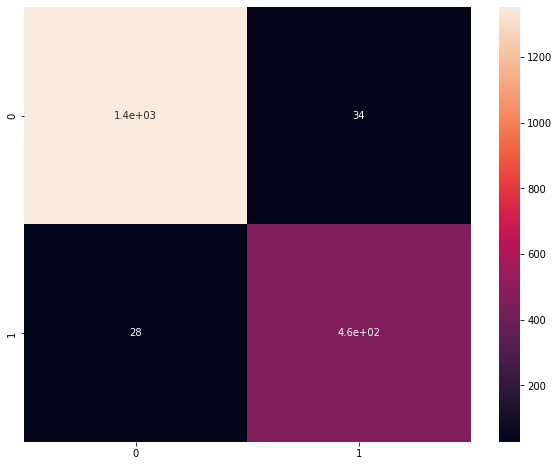

GradientBoostingClassifier(random_state=3301) Accuracy score:  0.9780748663101604

GradientBoostingClassifier(random_state=3301) Classification report:
               precision    recall  f1-score   support

           0   0.983465  0.987013  0.985236      1386
           1   0.962422  0.952479  0.957425       484

    accuracy                       0.978075      1870
   macro avg   0.972943  0.969746  0.971330      1870
weighted avg   0.978019  0.978075  0.978038      1870



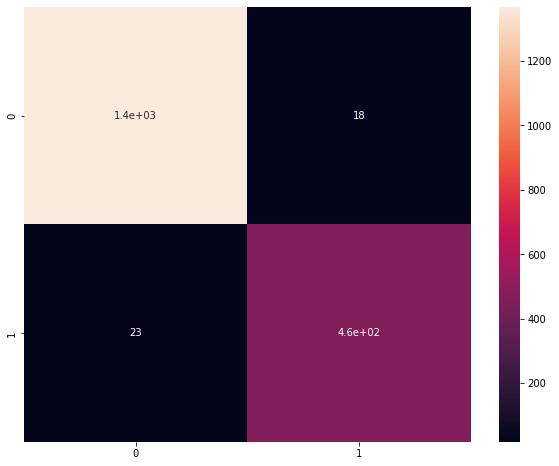

LogisticRegression(max_iter=500, random_state=3301, solver='liblinear') Accuracy score:  0.9887700534759358

LogisticRegression(max_iter=500, random_state=3301, solver='liblinear') Classification report:
               precision    recall  f1-score   support

           0   0.990654  0.994228  0.992438      1386
           1   0.983299  0.973140  0.978193       484

    accuracy                       0.988770      1870
   macro avg   0.986976  0.983684  0.985316      1870
weighted avg   0.988750  0.988770  0.988751      1870



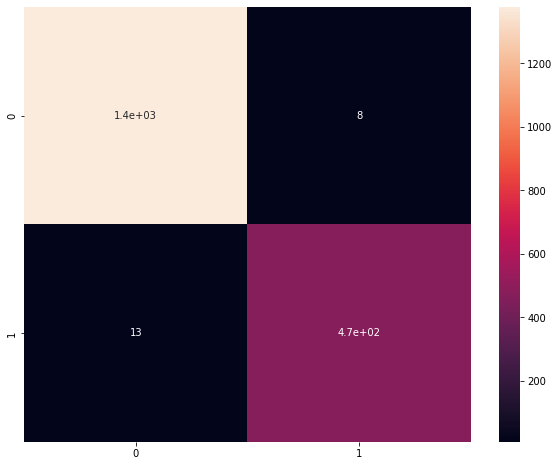

DecisionTreeClassifier(random_state=3301) Accuracy score:  0.967379679144385

DecisionTreeClassifier(random_state=3301) Classification report:
               precision    recall  f1-score   support

           0   0.974910  0.981241  0.978065      1386
           1   0.945263  0.927686  0.936392       484

    accuracy                       0.967380      1870
   macro avg   0.960087  0.954463  0.957229      1870
weighted avg   0.967237  0.967380  0.967279      1870



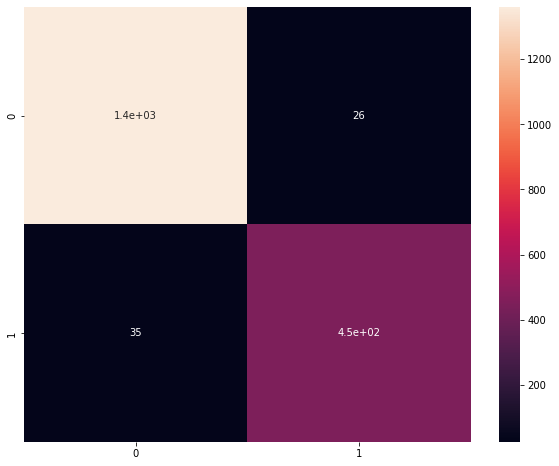

In [32]:
estimators = [
    RandomForestClassifier(random_state=3301),
    AdaBoostClassifier(random_state=3301),
    GradientBoostingClassifier(random_state=3301),
    LogisticRegression(solver="liblinear", random_state=3301, max_iter=500),
    DecisionTreeClassifier(random_state=3301),
]

# run
for esti in estimators:
    comp_esti(esti)

VotingClassifier(estimators=[('rfc', RandomForestClassifier(random_state=3301)),
                             ('svc',
                              LogisticRegression(max_iter=500,
                                                 random_state=3301,
                                                 solver='liblinear')),
                             ('grb',
                              GradientBoostingClassifier(random_state=3301))],
                 voting='soft') Accuracy score:  0.9903743315508021

VotingClassifier(estimators=[('rfc', RandomForestClassifier(random_state=3301)),
                             ('svc',
                              LogisticRegression(max_iter=500,
                                                 random_state=3301,
                                                 solver='liblinear')),
                             ('grb',
                              GradientBoostingClassifier(random_state=3301))],
                 voting='soft') Classification report:
    

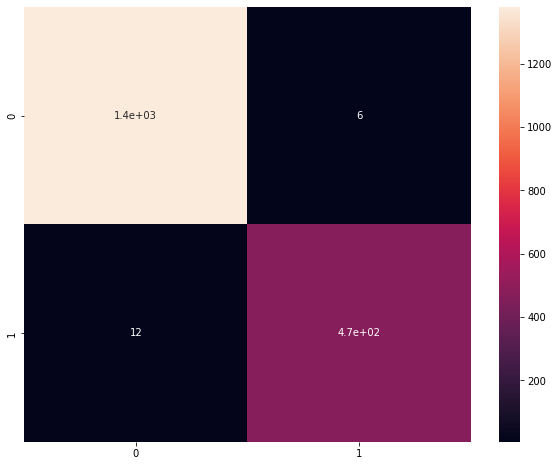

In [33]:
# Voting classifier
es1 = RandomForestClassifier(random_state=3301)
es2 = LogisticRegression(solver="liblinear", random_state=3301, max_iter=500)
es3 = GradientBoostingClassifier(random_state=3301)

esfinal = VotingClassifier(estimators=[
    ("rfc", es1), ("svc", es2), ("grb", es3)
], voting="soft")

comp_esti(esfinal)

We clearly observe that a **Voting Classifier** built out of **Random Forest Classifier**, **Logistic Regression** and **Gradient Boosting Classifier** performs the best out of all.

- Average Test set precision ~= **99%**
- Average Test set recall ~= **99%**

So our best classifier...

In [34]:
best_classifier = esfinal

best_classifier.fit(X_train_prepared, y_train)
preds = best_classifier.predict(X_test_prepared)

print(f"\n{esti} Classification report:\n", classification_report(y_test, preds, digits=6))


DecisionTreeClassifier(random_state=3301) Classification report:
               precision    recall  f1-score   support

           0   0.991379  0.995671  0.993521      1386
           1   0.987448  0.975207  0.981289       484

    accuracy                       0.990374      1870
   macro avg   0.989414  0.985439  0.987405      1870
weighted avg   0.990362  0.990374  0.990355      1870



**<span style="font-size: 20px; color: darkblue">If this notebook helped you a slightest bit, do consider upvoting it and leaving a comment below! Feel free to extend this notebook with more knowledge. Thank you! ❤️</span>**